In [32]:
unit_tsridx_dict_random

{'.features.Conv2d6': (array([ 52,  68,  90, 124, 176, 190, 200, 213, 250, 278, 294, 299, 308,
         328, 371], dtype=int64),
  array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int64),
  array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int64))}

Layer .features.Conv2d3 Sampled 100 units from feature tensor of shape (192, 27, 27)
Gaussian Fitting center (110.9, 110.9)
 Cov mat XX 119.9 YY 121.9 XY 4.0
act mat shape:  (1, 100)
act mat shape:  (1, 100)


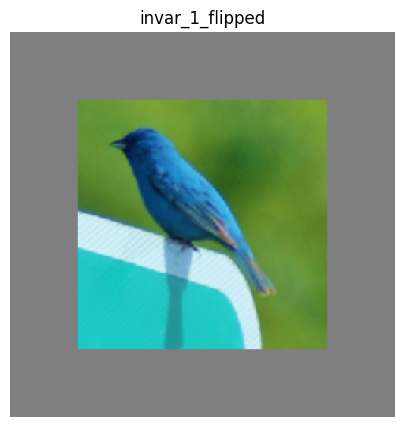

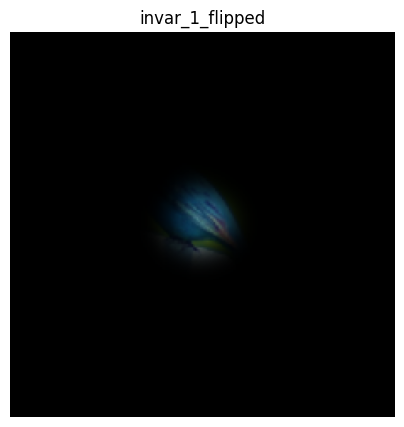

Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 3.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050
:-------------------->  invar_1_flipped.JPEG-100-MSE-conv5-fc6 evol finished! best score: -332.095
plot not saved


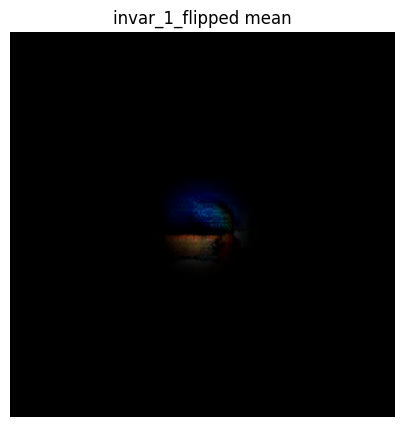

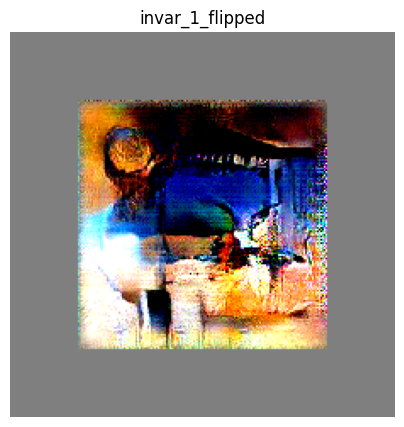

final MSE score:  332.09534
Cleanuping...
Cleanup hooks done.
Cleanup done.


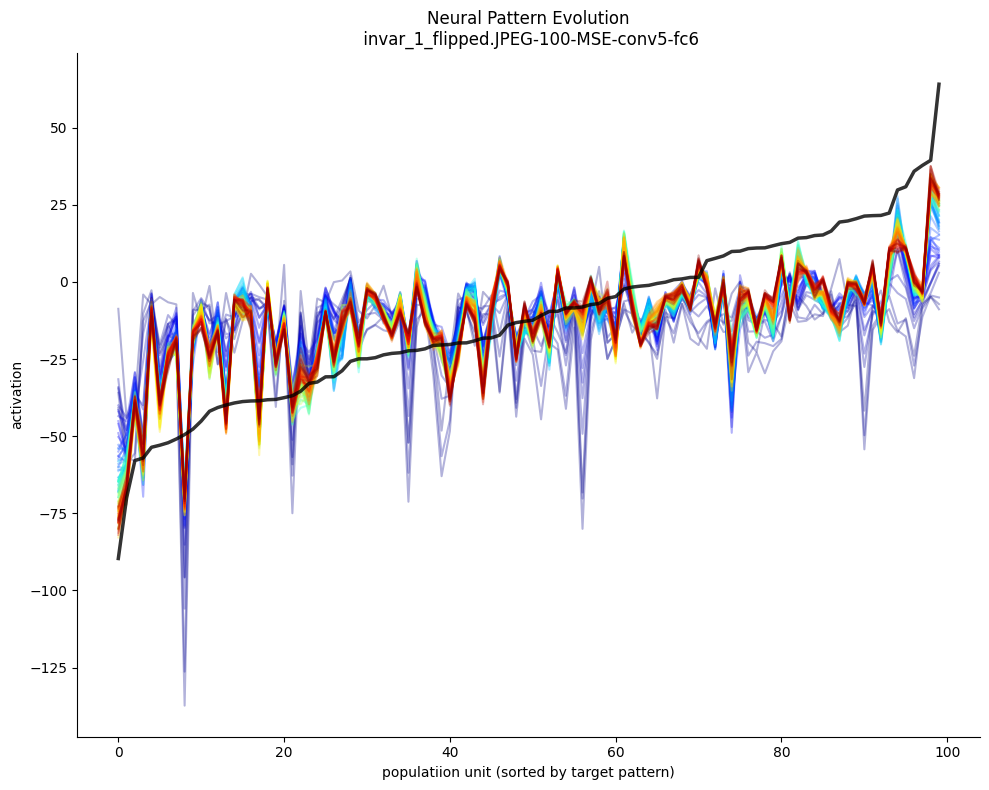

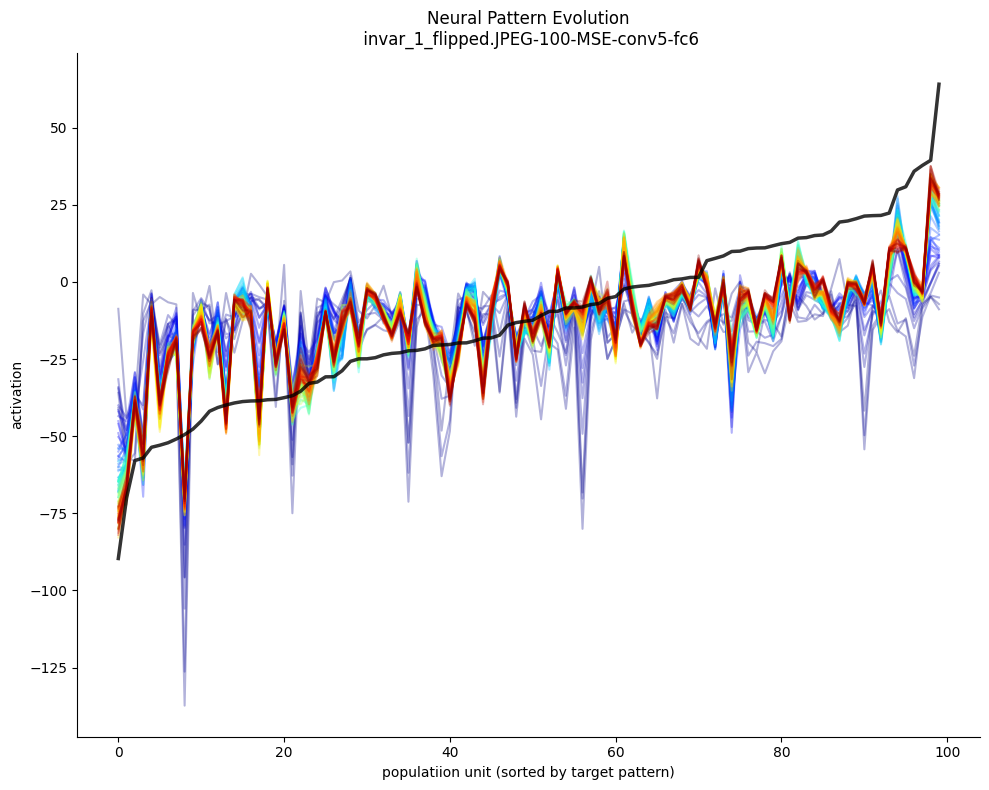

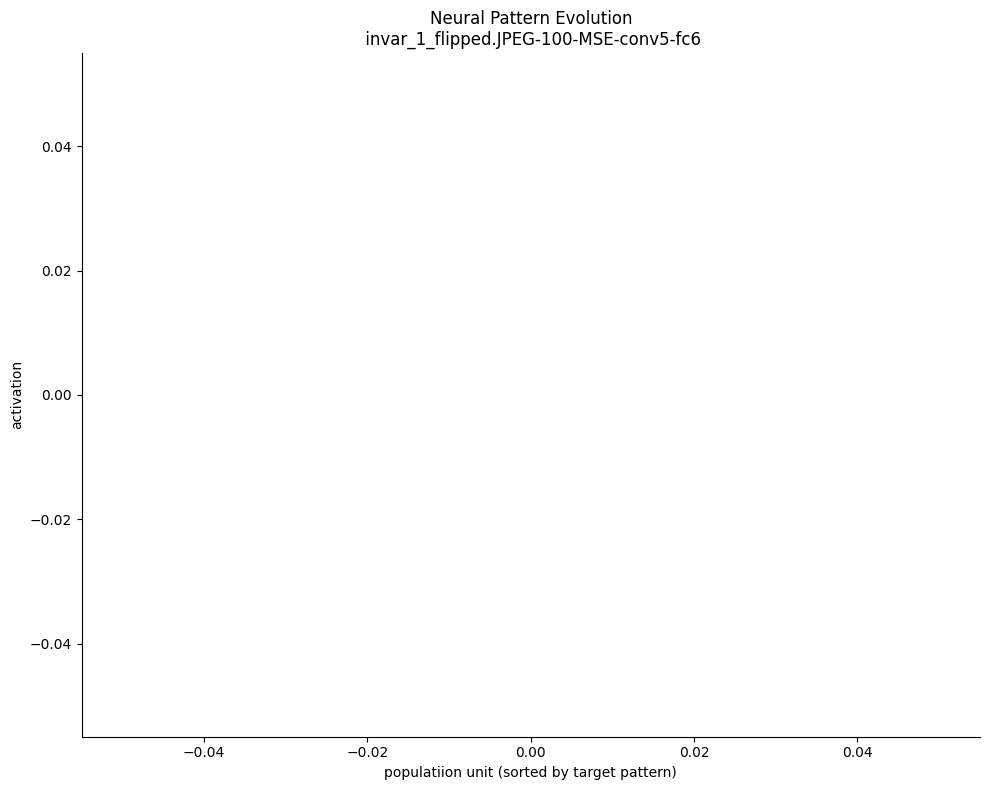

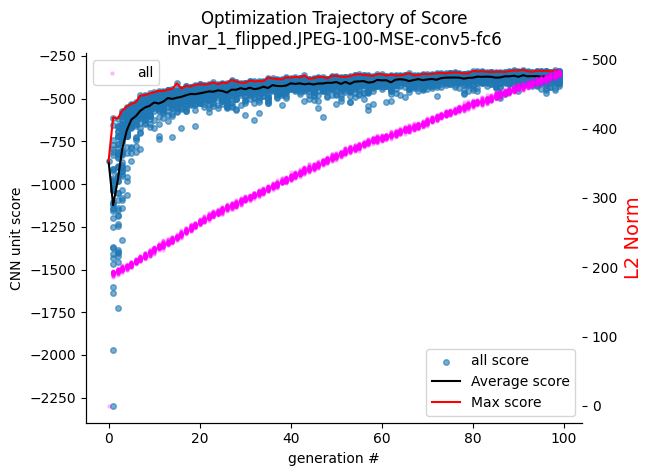

In [73]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
import matplotlib.pylab as plt
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this

from core.utils.GAN_utils import upconvGAN
from core.utils.Optimizers import CholeskyCMAES
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
#%% 
# Set parameters
refimgdir = r"C:\Data\cosine\insilico_experiments\data\tiny_set_image"

net_name = "alexnet" # corenet_s, resnet50, resnet50_linf_8, alexnet, vgg16, vgg16_bn, vgg19, vgg19_bn
layer_name = ['.features.Conv2d3']#'.BatchNorm2dbn3', '.features.Conv2d8', '.features.Conv2d6', '.features.Conv2d3']#[".features.Conv2d10", ".features.Conv2d6"]
layer_short = "conv5"
gan_name = "fc6"
input_size = (3, 227, 227)
img_size = (147, 147)
pading_size = (40, 40) 
popsize = round(100*1)
score_method = "MSE"

refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=227)

imgid = 1

targnm, target_imgtsr = refimgnms[imgid], refimgtsr[imgid:imgid + 1]
G = upconvGAN(gan_name).cuda()
G.requires_grad_(False)
code_length = G.codelen

scorer_random = TorchScorer(net_name)
module_names, module_types, module_spec = get_module_names(
        scorer_random.model, input_size, "cuda", False)
pop_resampling_id = 0
unit_mask_dict_random, unit_tsridx_dict_random = set_random_population_recording(
               scorer_random, layer_name, popsize=popsize, seed=pop_resampling_id)
#unit_mask_dict_random, unit_tsridx_dict_random = set_most_active_population_recording(
#                scorer_random, layer_name, target_imgtsr, pading_size, img_size, popsize=popsize)
#print("unit mask dict", unit_tsridx_dict_random)

fitdict_random = fr_estimatir(scorer_random, G, unit_tsridx_dict_random, layer_name, input_size,show_fig=False)

targ_actmat, target_imgtsr_resized = encode_image(scorer_random, target_imgtsr, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)
## BE CAREFULL WITH THIS-REMOVE IT LATER
#targ_actmat_shuff = np.random.permutation(targ_actmat[0])
#targ_actmat[0] = targ_actmat_shuff
# Set the value of k (number of elements to permute)
#k = popsize
# Randomly choose k indices
#selected_indices = np.random.choice(len(targ_actmat[0]), k, replace=False)
#complementary_indices = np.setdiff1d(np.arange(len(targ_actmat[0])), selected_indices)
#
# Create a copy of the array with only selected elements
#selected_elements = targ_actmat[0][selected_indices]
# Shuffle the selected elements
# shuffled_selected_elements = np.random.permutation(selected_elements)
# add noise to the selected elements
#shuffled_selected_elements = selected_elements + np.random.normal(0, 2*np.std(selected_elements), selected_elements.shape)
# Replace the selected elements in the original array with the shuffled ones
#targ_actmat[0][selected_indices] = shuffled_selected_elements


##
print("act mat shape: ", targ_actmat.shape)

targlabel = os.path.splitext(targnm)[0]
print("act mat shape: ", targ_actmat.shape)
target_imgtsr_resized_RF_masked =\
        (torch.from_numpy(np.absolute(fitdict_random["fitmap"][None,:,:])) / fitdict_random["fitmap"].max()) *\
        target_imgtsr_resized

# showt the tensor image 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized_RF_masked[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()


title_str = f"{targnm}-{popsize}-{score_method}-{layer_short}-{gan_name}"
#set objective function
objfunc = set_objective(score_method, targ_actmat, popul_mask=None, normalize=False)
## set optimizer
optimizer = CholeskyCMAES(code_length, population_size=None, init_sigma=3,
                init_code=np.zeros([1, code_length]), Aupdate_freq=10,
                maximize=True, random_seed=None, optim_params={})

codes_all, scores_all, actmat_all, generations, last_gem_img, last_gem_img_maske, best_imgs, best_imgs_RF_masked, best_scores, best_codes =\
        run_evol(scorer_random, objfunc, optimizer, G, reckey=layer_name, savedir=None, meta_data_df=None, trial_param_dict=None,
        titlestr =title_str, steps=100, RFresize=True, corner=pading_size, imgsize=img_size, RF_mask=fitdict_random["fitmap"], save_plot=None)
# 

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(last_gem_img_maske.mean(dim=0)))
ax.axis("off")
ax.set_title(targlabel+" mean")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(best_imgs[np.argmax(best_scores)]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()
print("final MSE score: ", np.square(actmat_all[scores_all.argmax(),:] - targ_actmat).mean())
figh = visualize_popul_act_evol(actmat_all, generations, targ_actmat, titlestr=title_str)
figh = visualize_popul_act_evol(actmat_all[:, selected_indices], generations, targ_actmat[:, selected_indices], titlestr=title_str)
figh = visualize_popul_act_evol(actmat_all[:, complementary_indices], generations, targ_actmat[:, complementary_indices], titlestr=title_str)
trajectory_fig = visualize_trajectory(scores_all, generations, codes_arr=codes_all,
                                                title_str=title_str)
scorer_random.cleanup()

In [65]:
np.std(selected_elements)/2

0.9216114282608032

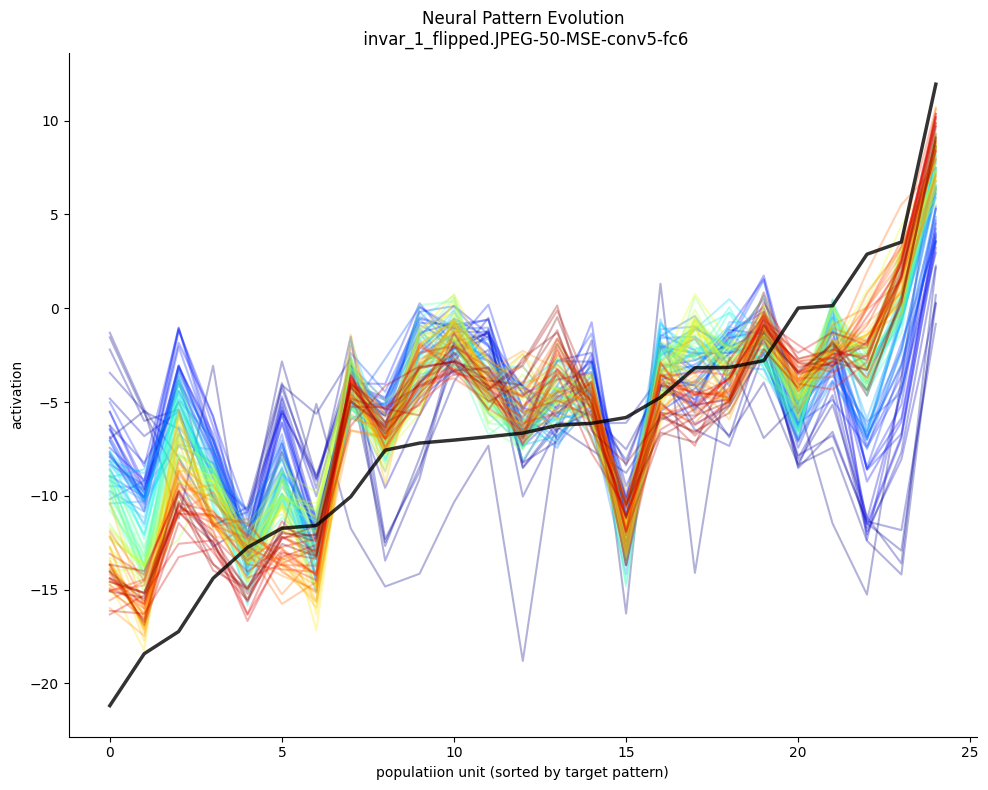

In [49]:
figh = visualize_popul_act_evol(actmat_all[:, selected_indices], generations, targ_actmat[:, selected_indices], titlestr=title_str)

In [33]:
k = 5
# Randomly choose k indices
selected_indices = np.random.choice(len(targ_actmat[0]), k, replace=False)
# find the complementary indices
complementary_indices = np.setdiff1d(np.arange(len(targ_actmat[0])), selected_indices)
# Create a copy of the array with only selected elements
selected_elements = targ_actmat[0][selected_indices]
# Shuffle the selected elements
shuffled_selected_elements = np.random.permutation(selected_elements)
# Replace the selected elements in the original array with the shuffled ones
targ_actmat[0][selected_indices] = shuffled_selected_elements

In [34]:
targ_actmat

array([[-3.7359345 ,  0.80768687, -2.0281675 , -1.3212656 , -2.4973493 ,
         1.1273569 , -2.535272  ,  0.0471997 , -1.8689538 ,  0.45673573,
        -1.4841437 , -0.5658526 ,  0.14691997,  2.316474  ,  0.23837462,
         0.55885977,  0.7143551 ,  0.21222416,  0.6552283 , -0.23306048,
         2.8936667 , -0.34247893, -0.9048306 , -0.4319656 , -4.331141  ,
        -0.11845416,  0.00873771, -0.09159546,  1.1531628 ,  2.704681  ,
         1.4981042 ,  3.4131014 ,  0.03557293,  1.1252084 ,  0.68922627,
         1.168983  , -1.8227844 ,  2.0115218 , -0.7661596 , -3.6102414 ,
        -2.5826004 , -1.2732799 ,  0.15831083,  1.2205626 ,  3.8828511 ,
        -2.918301  , -0.24354818,  0.76293063, -2.6924124 ,  0.10855653]],
      dtype=float32)